In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Global Variables

In [7]:
NUM_EMPLOYEES = 12
NUM_TASKS = 30
MAX_TASKS = 500
MAX_EMPLOYEES = 200
MAX_WORKLOAD = 20
ALPHA_WED = 0.5
task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/inference_30_task.csv'
employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/inference_12_employee.csv'

# Greedy

In [3]:
import pandas as pd
import numpy as np

# Load datasets
task_data = pd.read_csv(task_data_path)
employee_data = pd.read_csv(employee_data_path)
task_subset = task_data.iloc[:NUM_TASKS]
employee_subset = employee_data.iloc[:NUM_EMPLOYEES]
skill_columns = [col for col in task_data.columns if col not in ['task_id', 'story_points', 'project_id']]
task_skills = task_subset[skill_columns] / 5.0 # Preprocessing - Normalisasi keterampilan
emp_skills = employee_subset[skill_columns] / 5.0 # Preprocessing - Normalisasi keterampilan
task_df = task_subset
emp_df = employee_subset

# WED calculation
def calculate_wed(emp, task, alpha=ALPHA_WED):
    weights = 1 / (1 + alpha * np.maximum(0, emp - task))
    wed = np.sqrt(np.sum(weights * (emp - task) ** 2))
    return wed

# Greedy assignment
assignments = {emp_idx: [] for emp_idx in range(len(emp_skills))} # preprocessing - Changed to len(emp_skills) to fit DataFrame size
workload = np.zeros(len(emp_skills))  # Changed to len(emp_skills) to fit DataFrame size
weds_raw_greedy = []

np.random.seed(42) # Preprocessing - Pengacakan Urutan Tugas
for task_idx in np.random.permutation(NUM_TASKS):
    task = task_skills.iloc[task_idx].values
    sp = task_df['story_points'].iloc[task_idx] # Ekstraksi Story Points
    project_id = task_df['project_id'].iloc[task_idx] # Ekstraksi Project ID
    task_id = task_df.index[task_idx]
    best_emp, best_wed = None, float('inf')
    for emp_idx in range(len(emp_skills)): # Changed to len(emp_skills) to fit DataFrame size
        if workload[emp_idx] + sp <= MAX_WORKLOAD:
            emp = emp_skills.iloc[emp_idx].values
            wed = calculate_wed(emp, task)
            if wed < best_wed:
                best_wed, best_emp = wed, emp_idx
    if best_emp is not None:
        assignments[best_emp].append((task_id, project_id, sp, best_wed))
        workload[best_emp] += sp
        weds_raw_greedy.append(best_wed)

# Standardize WED scores for Greedy
weights_worst = 1 / (1 + ALPHA_WED * 1)
wed_raw_worst_greedy = np.sqrt(np.sum(weights_worst * (0 - 1) ** 2) * len(skill_columns))
wed_raw_best = 0
weds_standardized_greedy = [(wed_raw_worst_greedy - wed) / (wed_raw_worst_greedy - wed_raw_best) for wed in weds_raw_greedy]

# Prepare Greedy results
data = []
for emp_idx, tasks in assignments.items():
    employee_id = emp_df.index[emp_idx]
    projects = [proj for _, proj, _, _ in tasks] if tasks else []
    assigned_tasks = [task for task, _, _, _ in tasks] if tasks else []
    sum_sp = sum(sp for _, _, sp, _ in tasks) if tasks else 0
    wasted_sp = MAX_WORKLOAD - sum_sp
    similarity_scores = [wed for _, _, _, wed in tasks] if tasks else []
    data.append([employee_id, projects, assigned_tasks, sum_sp, wasted_sp, similarity_scores])

greedy_df = pd.DataFrame(data, columns=['employee', 'project', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
greedy_df.to_csv('greedy_weighted_method_corrected.csv', index=False)

# MOO

In [4]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 83.9 MB/s eta 0:00:00


<ipython-input-13-0aab3b3ceb68>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if task[index] > 0:
<ipython-input-13-0aab3b3ceb68>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = custom_we(emp[index], task[index])
<ipython-input-13-0aab3b3ceb68>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum += w * ((emp[index] - task[index])**2)
<ipython-input-13-0aab3b3ceb68>:48: FutureWarning: Series.__getitem__ treating keys as p

Restricted license - for non-production use only - expires 2026-11-23
Set parameter Presolve to value 2
Set parameter MIPFocus to value 1
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 0.1
Set parameter Threads to value 2
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
MIPGap  0.05
Heuristics  0.1
MIPFocus  1
Presolve  2
Threads  2

Optimize a model with 234 rows, 421 columns and 2052 nonzeros
Model fingerprint: 0x2abedf88
Variable types: 0 continuous, 421 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000
Presolve removed 60 rows and 1 columns
Presolve time: 0.03s
Presolved: 174 rows

<ipython-input-13-0aab3b3ceb68>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if task[index] > 0:
<ipython-input-13-0aab3b3ceb68>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w = custom_we(emp[index], task[index])
<ipython-input-13-0aab3b3ceb68>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum += w * ((emp[index] - task[index])**2)
<ipython-input-13-0aab3b3ceb68>:48: FutureWarning: Series.__getitem__ treating keys as p

  Clique: 45
  MIR: 4
  Zero half: 1

Explored 1 nodes (91 simplex iterations) in 0.08 seconds (0.01 work units)
Thread count was 2 (of 2 available processors)

Solution count 7: 2.73753 2.73344 2.73036 ... 2.50403

Optimal solution found (tolerance 5.00e-02)
Best objective 2.737533388251e+00, best bound 2.873689346522e+00, gap 4.9737%
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
MIPGap  0.05
Heuristics  0.1
MIPFocus  1
Presolve  2
Threads  2

Optimize a model with 234 rows, 421 columns and 2052 nonzeros
Model fingerprint: 0x0936a1ae
Variable types: 0 continuous, 421 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+00]

Loaded MIP start from previous

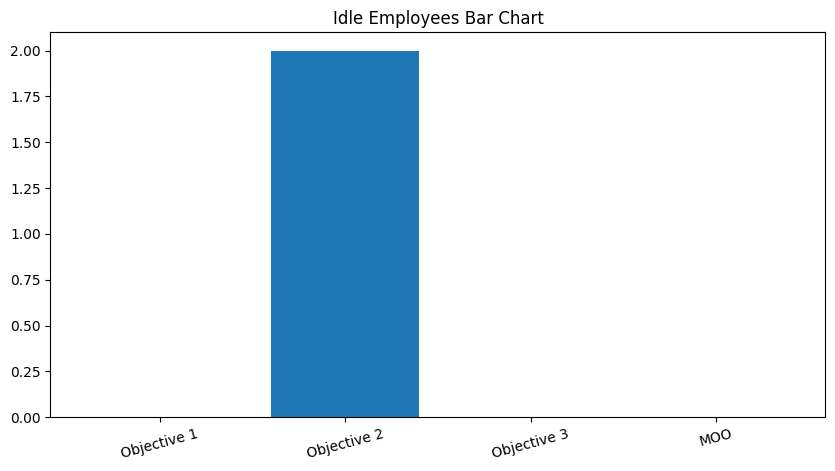

<ipython-input-13-0aab3b3ceb68>:388: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([similarity_score1, similarity_score2, similarity_score3, similarity_score_moo],


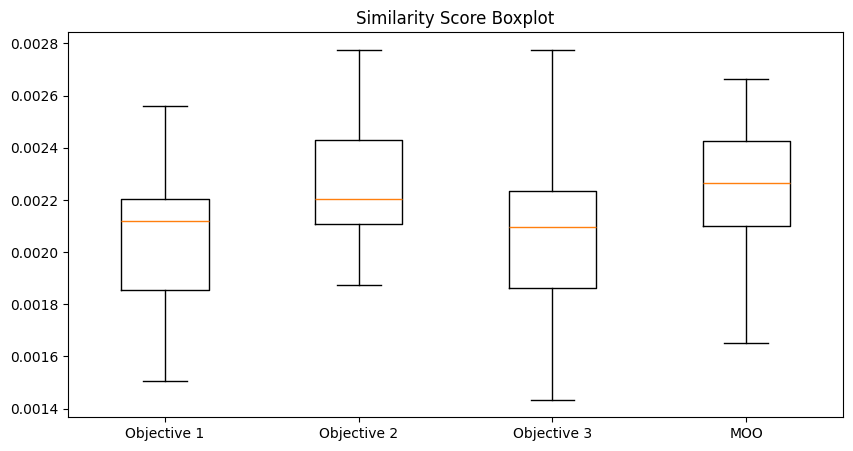

<ipython-input-13-0aab3b3ceb68>:401: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([workload_1, workload_2, workload_3, workload_moo],


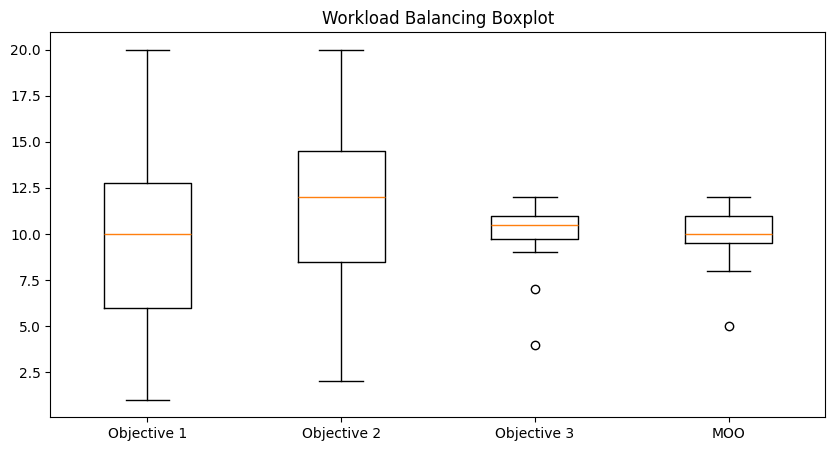

In [13]:
import math
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, Env, quicksum
import matplotlib.pyplot as plt
import os

# Stage 1: Loading & Preprocessing Data
def load_and_preprocess_data(new_employee_path, new_task_path):
    global employees, tasks, employee_skills_df, task_df, task_skills_df, story_points, company_tasks

    # Load data
    employee_skills_df = pd.read_csv(new_employee_path, index_col='employee_id').fillna(0)
    employee_skills_df.drop(columns=['no', 'Role'], inplace=True, errors='ignore')

    # Use all employees (removed subsetting to 10)
    employees = employee_skills_df.index.tolist()
    skills_name = employee_skills_df.columns[1:].tolist()

    task_df = pd.read_csv(new_task_path, index_col='task_id').fillna(0)

    # Use all tasks (removed subsetting to 20)
    tasks = task_df.index.tolist()
    company_names = list(set(task_df['project_id']))

    story_points = task_df['story_points'].to_dict()  # preprocessing - extract story points

    # Convert to dictionary each company and its task
    company_tasks = {}
    for company in company_names:
        company_tasks[company] = task_df[task_df['project_id'] == company].index.tolist()  # preprocessing - extract project id

    # Sort the company tasks
    company_tasks = dict(sorted(company_tasks.items()))

    task_skills_df = task_df.drop(columns=['project_id', 'story_points'])

# Stage 2: Calculating Similarity Error
def calculate_similarity_error():
    def custom_we(v1, v2, a=0.5):
        diff = v1 - v2
        w = 1 / (1 + a * np.maximum(0, diff))
        return w

    def euclidean_similarity(emp, task):
        sum = 0
        for index, metric in enumerate(emp):
            if task[index] > 0:
                w = custom_we(emp[index], task[index])
                sum += w * ((emp[index] - task[index])**2)
            else:
                sum += 0
        return math.sqrt(sum)

    global euclidean_similarity_score
    euclidean_similarity_score = {}
    count_no_match = 0

    for i in tasks:
        task_skills = task_skills_df.loc[i]
        for j in employees:
            employee_skills = employee_skills_df.loc[j]
            common_skills = [skill for skill in employee_skills.index if skill in task_skills.index]

            if common_skills:
                euclidean_similarity_score[(i, j)] = euclidean_similarity(employee_skills[common_skills], task_skills[common_skills])
                euclidean_similarity_score[(i, j)] = 1 / (1 + euclidean_similarity_score[(i, j)])
            else:
                count_no_match += 1

    return euclidean_similarity_score

# Stage 3: Construct Model, Build Decision Variable, Set Constraints
def construct_model_build_variables_set_constraints():
    global model, max_employee_workload, x, y, max_workload

    # Create Gurobi environment without license (free mode)
    env = Env()
    model = Model("task_assignment", env=env)

    max_employee_workload = 20

    # Set Gurobi parameters to improve performance
    model.setParam("Presolve", 2)
    model.setParam("MIPFocus", 1)
    model.setParam("MIPGap", 0.05)
    model.setParam("Heuristics", 0.1)
    model.setParam("Threads", 2)  # Adjusted for Colab

    # Create decision variables for x
    x = {}
    for k, task in company_tasks.items():
        for i in task:
            for j in employees:
                x[(i, j, k)] = model.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}_{k}')

    # Decision variable y represents cardinality of each employee and company
    y = {}
    for j in employees:
        for k in company_tasks.keys():
            y[(j, k)] = model.addVar(vtype=GRB.BINARY, name=f'y_{j}_{k}')

    # Decision variable max_workload
    max_workload = model.addVar(vtype=GRB.INTEGER, lb=0, ub=max_employee_workload, name='max_workload')

    # Integrate new variables
    model.update()

    # Constraint 1: Each task assigned to one talent
    for k, task in company_tasks.items():
        for i in task:
            model.addConstr(quicksum(x[(i, j, k)] for j in employees) == 1, name=f'task_{i}_assigned_once')

    # Constraint 2: If task i is assigned to employee j, then y[j, k] = 1
    for j in employees:
        for k, task in company_tasks.items():
            temp_sum = [x[(i, j, k)] for i in task]
            model.addConstr(quicksum(temp_sum) >= 1 - (1 - y[(j, k)]), name=f'y_{j}_{k}_enforced_if_any_task_assigned')
            model.addConstr(quicksum(temp_sum) <= (len(task) * y[(j, k)]), name=f'y_{j}_{k}_0_if_no_task_assigned')

    # Constraint 3: Each employee can only work on one task
    for j in employees:
        model.addConstr(quicksum(y[(j, k)] for k in company_tasks.keys()) <= 1, name=f'employee_{j}_single_task')

    # Constraint 4: Employee workload doesn't exceed max_workload
    for j in employees:
        for k, tasks in company_tasks.items():
            model.addConstr(
                quicksum(story_points[i] * x[(i, j, k)] for i in tasks)
                <= max_workload
            )

    # Constraint 5: max_workload is greater than or equal to the workload of each employee
    for j in employees:
        model.addConstr(
            max_workload >= quicksum(story_points[i] * x[(i, j, k)] for k, tasks in company_tasks.items() for i in tasks)
        )

    model.update()

# Stage 4: Objective 1 Optimization (Minimize Idle Employees)
def objective1_optimization():
    global x_hat_obj1
    I = [1 - quicksum(y[j, k] for k in company_tasks.keys()) for j in employees]
    I_total_idle_employee = quicksum(I)
    model.setObjective(I_total_idle_employee, GRB.MINIMIZE)
    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        mu_Z_star[1] = model.ObjVal
        x_hat_obj1 = {}
        for j in employees:
            task = []
            sim = []
            sp = 0
            wasted_sp = 0
            comp = []
            for k, tasks in company_tasks.items():
                for i in tasks:
                    if x[(i, j, k)].X == 1:
                        task.append(i)
                        sim.append(euclidean_similarity_score[(i, j)])
                        comp.append(k)
                        sp += story_points[i]
            if sp > 0:
                wasted_sp = max_employee_workload - sp
                x_hat_obj1[j] = (comp, task, sp, wasted_sp, sim)

        # Convert to DataFrame
        global result_obj1
        result_obj1 = pd.DataFrame([(key, value[0], value[1], value[2], value[3], value[4]) for key, value in x_hat_obj1.items()],
                                 columns=['employee', 'company', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
        result_obj1.set_index('employee', inplace=True)
        os.makedirs('./output', exist_ok=True)
        result_obj1.to_csv("./output/result_obj1.csv")
    else:
        x_hat_obj1 = {}

# Stage 5: Objective 2 Optimization (Minimize Similarity Error)
def objective2_optimization():
    global x_hat_obj2
    E_total_similarity_score = quicksum(euclidean_similarity_score[(i, j)] * x[(i, j, k)] for k, tasks in company_tasks.items() for i in tasks for j in employees)
    model.setObjective(E_total_similarity_score, GRB.MAXIMIZE)
    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        mu_Z_star[2] = model.ObjVal
        x_hat_obj2 = {}
        for j in employees:
            task = []
            sim = []
            sp = 0
            wasted_sp = 0
            comp = []
            for k, tasks in company_tasks.items():
                for i in tasks:
                    if x[(i, j, k)].X == 1:
                        task.append(i)
                        sim.append(euclidean_similarity_score[(i, j)])
                        comp.append(k)
                        sp += story_points[i]
            if sp > 0:
                wasted_sp = max_employee_workload - sp
                x_hat_obj2[j] = (comp, task, sp, wasted_sp, sim)

        # Convert to DataFrame
        global result_obj2
        result_obj2 = pd.DataFrame([(key, value[0], value[1], value[2], value[3], value[4]) for key, value in x_hat_obj2.items()],
                                 columns=['employee', 'company', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
        result_obj2.set_index('employee', inplace=True)
        result_obj2.to_csv("./output/result_obj2.csv")
    else:
        x_hat_obj2 = {}

# Stage 6: Objective 3 Optimization (Minimize Max Workload)
def objective3_optimization():
    global x_hat_obj3
    model.setObjective(max_workload, GRB.MINIMIZE)
    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        mu_Z_star[3] = model.ObjVal
        x_hat_obj3 = {}
        for j in employees:
            task = []
            sim = []
            sp = 0
            wasted_sp = 0
            comp = []
            for k, tasks in company_tasks.items():
                for i in tasks:
                    if x[(i, j, k)].X == 1:
                        task.append(i)
                        sim.append(euclidean_similarity_score[(i, j)])
                        comp.append(k)
                        sp += story_points[i]
            if sp > 0:
                wasted_sp = max_employee_workload - sp
                x_hat_obj3[j] = (comp, task, sp, wasted_sp, sim)

        # Convert to DataFrame
        global result_obj3
        result_obj3 = pd.DataFrame([(key, value[0], value[1], value[2], value[3], value[4]) for key, value in x_hat_obj3.items()],
                                 columns=['employee', 'company', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
        result_obj3.set_index('employee', inplace=True)
        result_obj3.to_csv("./output/result_obj3.csv")
    else:
        x_hat_obj3 = {}

# Stage 7: MOO Optimization
def moo_optimization():
    global x_hat_moo

    # Define weight dictionary for each objective
    Weight = {
        1: 0.05,  # Minimize idle employees
        2: 0.85,  # Minimize similarity error
        3: 0.1    # Minimize max workload
    }

    # Define the deviation plus and minus variables
    d_plus = {}
    d_minus = {}

    # Add variables for d_plus and d_minus with specific conditions
    for i in range(1, 4):
        if i != 3:
            d_plus[i] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"d_plus_{i}")
        if i != 1:
            d_minus[i] = model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"d_minus_{i}")

    # Set specific variables to zero
    d_minus[1] = 0
    d_plus[3] = 0

    mu_Z = {1: quicksum(1 - quicksum(y[j, k] for k in company_tasks.keys()) for j in employees),
            2: quicksum(euclidean_similarity_score[(i, j)] * x[(i, j, k)] for k, tasks in company_tasks.items() for i in tasks for j in employees),
            3: max_workload}

    mu_Z_star_obj = {i: 1 / value if value != 0 else 0 for i, value in mu_Z_star.items()}

    # Constraints for deviation variables
    for k, w in Weight.items():
        if w != 0:
            model.addConstr(mu_Z[k] - d_plus[k] + d_minus[k] == mu_Z_star[k])

    # Define objective D
    D = quicksum((Weight[i] * (d_plus[i] + d_minus[i])) * mu_Z_star_obj[i] for i in range(1, 4))

    model.setObjective(D, GRB.MINIMIZE)
    model.optimize()

    if model.status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
        mu_Z_star[4] = model.ObjVal
        x_hat_moo = {}
        for j in employees:
            task = []
            sim = []
            sp = 0
            wasted_sp = 0
            comp = []
            for k, tasks in company_tasks.items():
                for i in tasks:
                    if x[(i, j, k)].X == 1:
                        task.append(i)
                        sim.append(euclidean_similarity_score[(i, j)])
                        comp.append(k)
                        sp += story_points[i]
            if sp > 0:
                wasted_sp = max_employee_workload - sp
                x_hat_moo[j] = (comp, task, sp, wasted_sp, sim)

        # Convert to DataFrame
        global result_moo
        result_moo = pd.DataFrame([(key, value[0], value[1], value[2], value[3], value[4]) for key, value in x_hat_moo.items()],
                                columns=['employee', 'company', 'assigned_task', 'sum_sp', 'wasted_sp', 'similarity_score'])
        result_moo.set_index('employee', inplace=True)
        result_moo.to_csv("/content/drive/MyDrive/Skripsi/Resources/Output/test_result_moo.csv")
    else:
        x_hat_moo = {}

# Stage 8: Data Visualization
def data_visualization():
    # Normalization function for similarity score
    def normalize_assessment_scores(assessment_scores_df, min_score, max_score, weighted_euclidean=False):
        normalized_scores_df = assessment_scores_df.copy()
        for index, score in enumerate(normalized_scores_df):
            if weighted_euclidean:
                normalized_scores_df[index] = 1 - ((score - min_score) / (max_score - min_score))
            else:
                normalized_scores_df[index] = (score - min_score) / (max_score - min_score)
        return normalized_scores_df

    worst_score = 40.311288741492746
    best_score = 0

    # Calculate idle employees
    total_employee = len(employees)
    total_sp = sum(story_points.values())

    # Objective 1
    total_active_employee_obj1 = len(set(x_hat_obj1.keys()))
    total_active_sp_obj1 = sum(value[2] for value in x_hat_obj1.values())
    total_idle_employee_obj1 = total_employee - total_active_employee_obj1
    total_wasted_sp_obj1 = total_sp - total_active_sp_obj1

    # Objective 2
    total_active_employee_obj2 = len(set(x_hat_obj2.keys()))
    total_active_sp_obj2 = sum(value[2] for value in x_hat_obj2.values())
    total_idle_employee_obj2 = total_employee - total_active_employee_obj2
    total_wasted_sp_obj2 = total_sp - total_active_sp_obj2

    # Objective 3
    total_active_employee_obj3 = len(set(x_hat_obj3.keys()))
    total_active_sp_obj3 = sum(value[2] for value in x_hat_obj3.values())
    total_idle_employee_obj3 = total_employee - total_active_employee_obj3
    total_wasted_sp_obj3 = total_sp - total_active_sp_obj3

    # MOO
    total_active_employee_moo = len(set(x_hat_moo.keys()))
    total_active_sp_moo = sum(value[2] for value in x_hat_moo.values())
    total_idle_employee_moo = total_employee - total_active_employee_moo
    total_wasted_sp_moo = total_sp - total_active_sp_moo

    # Create bar chart of idle employees
    plt.figure(figsize=(10, 5))
    plt.bar(['Objective 1', 'Objective 2', 'Objective 3', 'MOO'],
            [total_idle_employee_obj1, total_idle_employee_obj2, total_idle_employee_obj3, total_idle_employee_moo])
    plt.title('Idle Employees Bar Chart')
    plt.xticks(rotation=15)
    plt.savefig("./output/idle_emp_all.png")
    plt.show()

    # Calculate similarity score
    similarity_score1 = result_obj1['similarity_score'].explode().reset_index(drop=True)
    similarity_score2 = result_obj2['similarity_score'].explode().reset_index(drop=True)
    similarity_score3 = result_obj3['similarity_score'].explode().reset_index(drop=True)
    similarity_score_moo = result_moo['similarity_score'].explode().reset_index(drop=True)

    # Normalize values
    similarity_score1 = normalize_assessment_scores(similarity_score1, worst_score, best_score, weighted_euclidean=True)
    similarity_score2 = normalize_assessment_scores(similarity_score2, worst_score, best_score, weighted_euclidean=True)
    similarity_score3 = normalize_assessment_scores(similarity_score3, worst_score, best_score, weighted_euclidean=True)
    similarity_score_moo = normalize_assessment_scores(similarity_score_moo, worst_score, best_score, weighted_euclidean=True)

    # Boxplot for similarity scores
    plt.figure(figsize=(10, 5))
    plt.boxplot([similarity_score1, similarity_score2, similarity_score3, similarity_score_moo],
                labels=['Objective 1', 'Objective 2', 'Objective 3', 'MOO'])
    plt.title('Similarity Score Boxplot')
    plt.savefig("./output/similarity_all.png")
    plt.show()

    # Workload balancing
    workload_1 = result_obj1['sum_sp'].explode().reset_index(drop=True)
    workload_2 = result_obj2['sum_sp'].explode().reset_index(drop=True)
    workload_3 = result_obj3['sum_sp'].explode().reset_index(drop=True)
    workload_moo = result_moo['sum_sp'].explode().reset_index(drop=True)

    plt.figure(figsize=(10, 5))
    plt.boxplot([workload_1, workload_2, workload_3, workload_moo],
                labels=['Objective 1', 'Objective 2', 'Objective 3', 'MOO'])
    plt.title('Workload Balancing Boxplot')
    plt.savefig("./output/workload_all.png")
    plt.show()

# Main function to execute all stages
def main():
    global mu_Z_star
    mu_Z_star = {i: 0.00 for i in range(1, 5)}

    # Load data
    load_and_preprocess_data(employee_data_path, task_data_path)

    # Calculate similarity
    calculate_similarity_error()

    # Construct model
    construct_model_build_variables_set_constraints()

    # Optimize objectives
    objective1_optimization()
    objective2_optimization()
    objective3_optimization()
    moo_optimization()

    # Visualize results
    data_visualization()

if __name__ == "__main__":
    # Define input paths (replace with your actual CSV paths)
    main()

# DQN

## Training

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from gym import spaces
import random
from collections import deque
import time
from torch.cuda.amp import GradScaler as AmpGradScaler
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import os

# Tentukan perangkat komputasi: GPU jika tersedia, jika tidak gunakan CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")

# Definisi variabel global untuk konfigurasi pelatihan dan lingkungan
# MAX_TASKS = 500  # Jumlah maksimum tugas
# MAX_EMPLOYEES = 200  # Jumlah maksimum karyawan
NUM_EPISODES = 50  # Jumlah episode pelatihan
LEARNING_RATE = 3e-4  # Laju pembelajaran untuk optimisasi jaringan saraf
INITIAL_EPSILON = 1.0  # Nilai awal epsilon untuk eksplorasi epsilon-greedy
MIN_EPSILON = 0.1  # Nilai minimum epsilon
GAMMA = 0.99  # Faktor diskon untuk perhitungan Q-value
MEMORY_SIZE = 50000  # Kapasitas memori replay
BATCH_SIZE = 64  # Ukuran batch untuk pembelajaran
TARGET_UPDATE_FREQ = 1000  # Frekuensi pembaruan jaringan target
DQN_HIDDEN_DIM = 256  # Dimensi lapisan tersembunyi jaringan DQN
MAX_WORKLOAD = 20  # Batas maksimum beban kerja per karyawan
ALPHA_WED = 0.5  # Parameter untuk Weighted Euclidean Distance (WED)
REASSIGNMENT_BONUS = 5.0  # Bonus untuk reassignment yang meningkatkan keseimbangan
REASSIGNMENT_THRESHOLD = 5.0  # Ambang deviasi standar untuk memicu reassignment
MAX_REASSIGN_PER_TASK = 3  # Batas maksimum reassignment per tugas
STEP_PENALTY = -0.01  # Penalti per langkah untuk mendorong efisiensi
COMPLETION_BONUS = 50.0  # Bonus saat semua tugas selesai dialokasikan

SAVE_EPISODES = [20]  # Episode untuk menyimpan checkpoint
MAX_STEPS_PER_EPISODE = MAX_TASKS  # Maksimum langkah per episode
TOTAL_STEPS = NUM_EPISODES * MAX_STEPS_PER_EPISODE  # Total langkah pelatihan
DECAY_RATE_EPS = -np.log(MIN_EPSILON / INITIAL_EPSILON) / TOTAL_STEPS  # Laju peluruhan epsilon

# Path untuk data dan penyimpanan model
# task_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_task.csv'
# employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/Datasets/fixed_data_employee.csv'
model_save_path = '/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_model.pth'
agent_save_path = '/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_agent_params.pth'

# Direktori untuk menyimpan log
log_dir = '/content/drive/MyDrive/Skripsi/Logs/'
os.makedirs(log_dir, exist_ok=True)

# Kelas lingkungan untuk simulasi penugasan tugas
class TaskAssignmentEnv(gym.Env):
    def __init__(self, task_data, employee_data, max_tasks=MAX_TASKS, max_employees=MAX_EMPLOYEES):
        super(TaskAssignmentEnv, self).__init__()
        # Inisialisasi jumlah tugas dan karyawan
        self.num_tasks = len(task_data)
        self.num_employees = len(employee_data)
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        self.max_workload = MAX_WORKLOAD

        # Memuat dan memproses data tugas dan karyawan
        task_subset = task_data.iloc[:self.num_tasks]
        employee_subset = employee_data.iloc[:self.num_employees]
        skill_columns = [col for col in task_data.columns if col not in ['task_id', 'story_points', 'project_id']]
        # Mengonversi ID proyek menjadi indeks unik
        project_id_map = {pid: idx + 1 for idx, pid in enumerate(task_subset['project_id'].unique())}
        project_ids = task_subset['project_id'].map(project_id_map).values
        # Normalisasi data keterampilan dan story points
        task_skills_df = task_subset[skill_columns].fillna(0).astype(np.float32)
        employee_skills_df = employee_subset[skill_columns].fillna(0).astype(np.float32)
        story_points_df = task_subset['story_points'].astype(np.float32)

        # Konversi data ke tensor dan lakukan padding untuk ukuran maksimum
        self.task_skills = F.pad(
            torch.tensor(task_skills_df.values / 5.0, dtype=torch.float32, device=device),
            (0, 0, 0, max_tasks - self.num_tasks),
            'constant', 0
        )
        self.employee_skills = F.pad(
            torch.tensor(employee_skills_df.values / 5.0, dtype=torch.float32, device=device),
            (0, 0, 0, max_employees - self.num_employees),
            'constant', 0
        )
        self.story_points = F.pad(
            torch.tensor(story_points_df.values, dtype=torch.float32, device=device),
            (0, max_tasks - self.num_tasks),
            'constant', 0
        )
        self.project_ids = F.pad(
            torch.tensor(project_ids, dtype=torch.long, device=device),
            (0, max_tasks - self.num_tasks),
            'constant', -1
        )
        self.total_story_points = torch.sum(self.story_points[:self.num_tasks]).item()
        self.num_skills = len(skill_columns)

        # Definisi ruang observasi dan aksi
        self.observation_space = spaces.Dict({
            'state_matrix': spaces.Box(low=0, high=1, shape=(max_tasks, 5), dtype=np.float32),
            'workload_matrix': spaces.Box(low=0, high=MAX_WORKLOAD, shape=(max_employees,), dtype=np.float32),
            'global_features': spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32),
            'task_mask': spaces.Box(low=0, high=1, shape=(max_tasks,), dtype=np.float32)
        })
        self.action_space = spaces.MultiDiscrete([2, self.num_tasks, self.num_employees])
        self.reset()

    # Mengatur ulang lingkungan untuk episode baru
    def reset(self):
        # Inisialisasi beban kerja, penugasan, dan status proyek
        self.workloads = torch.zeros(self.max_employees, device=device, dtype=torch.float32)
        self.assignments = torch.full((self.max_tasks,), -1, dtype=torch.long, device=device)
        self.remaining_tasks = torch.arange(self.num_tasks, device=device, dtype=torch.long)
        self.employee_projects = torch.full((self.max_employees,), -1, dtype=torch.long, device=device)
        self.wed_scores = []  # Menyimpan skor WED untuk analisis
        self.reassign_counts = torch.zeros(self.max_tasks, device=device, dtype=torch.long)  # Melacak reassignment per tugas
        self.total_reassigns = 0  # Total reassignment dalam episode
        self._initialize_state_matrix()
        return self._get_obs()

    # Inisialisasi matriks status berdasarkan kesamaan keterampilan
    def _initialize_state_matrix(self):
        # Menghitung kesamaan antara keterampilan tugas dan karyawan menggunakan WED
        task_skills_expanded = self.task_skills[:self.num_tasks].unsqueeze(1).expand(-1, self.max_employees, -1)
        emp_skills_expanded = self.employee_skills.unsqueeze(0).expand(self.num_tasks, -1, -1)
        diff = emp_skills_expanded - task_skills_expanded
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device, dtype=torch.float32)))
        mask = self.task_skills[:self.num_tasks].unsqueeze(1).expand(-1, self.max_employees, -1) > 0
        weighted_diff = weights * mask * (emp_skills_expanded - task_skills_expanded) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff, dim=2))
        num_skills_per_task = torch.sum(self.task_skills[:self.num_tasks] > 0, dim=1).unsqueeze(1).expand(-1, self.max_employees)
        wed_worst = torch.sqrt(num_skills_per_task * (1.0 ** 2))
        wed_worst = torch.where(num_skills_per_task > 0, wed_worst, torch.tensor(1.0, device=device, dtype=torch.float32))
        similarity_matrix = (1 - (wed / wed_worst)).to(dtype=torch.float32)

        # Ambil 5 nilai kesamaan tertinggi untuk setiap tugas
        top_k = 5
        self.state_matrix = torch.topk(similarity_matrix, k=top_k, dim=1).values
        self.state_matrix = F.pad(self.state_matrix, (0, 0, 0, self.max_tasks - self.num_tasks), 'constant', 0)

    # Memperbarui matriks status untuk tugas tertentu setelah penugasan
    def _update_state_matrix(self, task_idx, emp_idx):
        task_skills_expanded = self.task_skills[task_idx].unsqueeze(0).expand(self.max_employees, -1)
        emp_skills_expanded = self.employee_skills.expand(self.max_employees, -1)
        diff = emp_skills_expanded - task_skills_expanded
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device, dtype=torch.float32)))
        mask = task_skills_expanded > 0
        weighted_diff = weights * mask * (emp_skills_expanded - task_skills_expanded) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff, dim=1))
        num_skills = torch.sum(mask.float(), dim=1)
        wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills[0] > 0 else 1.0
        similarities = 1 - (wed / wed_worst)
        top_k_similarities = torch.topk(similarities, k=5, dim=0).values
        self.state_matrix[task_idx] = top_k_similarities

    # Mengembalikan observasi saat ini
    def _get_obs(self):
        workload_matrix = self.workloads
        prop_remaining = len(self.remaining_tasks) / self.num_tasks if self.num_tasks > 0 else 0.0
        num_idle = torch.sum(self.workloads[:self.num_employees] == 0).item()
        prop_idle = num_idle / self.num_employees if self.num_employees > 0 else 0.0
        std_workload = torch.std(self.workloads[:self.num_employees]).item() / self.max_workload
        global_features = torch.tensor([prop_remaining, prop_idle, std_workload], device=device, dtype=torch.float32)
        task_mask = torch.zeros(self.max_tasks, device=device, dtype=torch.float32)
        if len(self.remaining_tasks) > 0:
            task_mask[self.remaining_tasks] = 1
        return {
            'state_matrix': self.state_matrix,
            'workload_matrix': workload_matrix,
            'global_features': global_features,
            'task_mask': task_mask
        }

    # Melakukan satu langkah dalam lingkungan
    def step(self, action):
        action_type, task_idx, emp_idx = action
        done = False
        reward = {'similarity': 0.0, 'workload': 0.0, 'idle': 0.0}
        info = {'action_valid': True}

        # Validasi indeks tugas dan karyawan
        if emp_idx < 0 or emp_idx >= self.num_employees or task_idx < 0 or task_idx >= self.num_tasks:
            reward['similarity'] = -1.0
            info['action_valid'] = False
            info['invalid_action'] = 'Indeks tugas atau karyawan tidak valid'
            return self._get_obs(), reward, done, info

        # Hitung deviasi standar beban kerja sebelum aksi
        current_std = torch.std(self.workloads[:self.num_employees]).item()

        # Penugasan baru (action_type = 0)
        if action_type == 0:
            if task_idx not in self.remaining_tasks:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Tugas sudah ditugaskan'
                return self._get_obs(), reward, done, info
            task_project = self.project_ids[task_idx]
            emp_project = self.employee_projects[emp_idx]
            current_workload = self.workloads[emp_idx]
            if emp_project != -1 and emp_project != task_project:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Proyek berbeda'
                return self._get_obs(), reward, done, info
            if current_workload + self.story_points[task_idx] > self.max_workload:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Melebihi beban kerja'
                return self._get_obs(), reward, done, info
            was_idle = (self.workloads[emp_idx] == 0)
            self.assignments[task_idx] = emp_idx
            self.workloads[emp_idx] += self.story_points[task_idx]
            self.remaining_tasks = self.remaining_tasks[self.remaining_tasks != task_idx]
            if self.employee_projects[emp_idx] == -1:
                self.employee_projects[emp_idx] = task_project
            self._update_state_matrix(task_idx, emp_idx)

        # Reassignment (action_type = 1)
        elif action_type == 1:
            if task_idx in self.remaining_tasks:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Tugas belum ditugaskan'
                return self._get_obs(), reward, done, info
            if self.reassign_counts[task_idx] >= MAX_REASSIGN_PER_TASK:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Batas reassignment tercapai'
                return self._get_obs(), reward, done, info
            current_emp_idx = self.assignments[task_idx]
            if current_emp_idx == emp_idx:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Tugas sudah ditugaskan ke karyawan ini'
                return self._get_obs(), reward, done, info
            task_project = self.project_ids[task_idx]
            emp_project = self.employee_projects[emp_idx]
            current_workload = self.workloads[emp_idx]
            if emp_project != -1 and emp_project != task_project:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Proyek berbeda untuk karyawan baru'
                return self._get_obs(), reward, done, info
            if current_workload + self.story_points[task_idx] > self.max_workload:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                info['invalid_action'] = 'Melebihi beban kerja karyawan baru'
                return self._get_obs(), reward, done, info
            self.workloads[current_emp_idx] -= self.story_points[task_idx]
            emp_tasks = (self.assignments == current_emp_idx) & (self.project_ids == task_project)
            emp_tasks[task_idx] = False
            if not torch.any(emp_tasks):
                self.employee_projects[current_emp_idx] = -1
            was_idle = (self.workloads[emp_idx] == 0)
            self.assignments[task_idx] = emp_idx
            self.workloads[emp_idx] += self.story_points[task_idx]
            if self.employee_projects[emp_idx] == -1:
                self.employee_projects[emp_idx] = task_project
            self.reassign_counts[task_idx] += 1
            self.total_reassigns += 1
            self._update_state_matrix(task_idx, emp_idx)

        else:
            reward['similarity'] = -1.0
            info['action_valid'] = False
            info['invalid_action'] = 'Tipe aksi tidak valid'
            return self._get_obs(), reward, done, info

        # Hitung deviasi standar setelah aksi dan berikan reward keseimbangan
        new_std = torch.std(self.workloads[:self.num_employees]).item()
        std_change = new_std - current_std
        if std_change < 0:
            reward['workload'] += 0.5
        elif std_change > 0:
            reward['workload'] -= 0.3

        # Hitung reward kesamaan berdasarkan WED
        task_skills_t = self.task_skills[task_idx]
        emp_skills_e = self.employee_skills[emp_idx]
        diff = emp_skills_e - task_skills_t
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device, dtype=torch.float32)))
        mask = task_skills_t > 0
        weighted_diff = weights[mask] * (emp_skills_e[mask] - task_skills_t[mask]) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff))
        num_skills = torch.sum(mask.float())
        wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills > 0 else 1.0
        similarity = 1 - (wed / wed_worst) if wed_worst > 0 else 0.0
        info['similarity'] = similarity.item()
        self.wed_scores.append(wed.item())

        if action_type == 0:
            reward['similarity'] = similarity.item()
            if was_idle:
                reward['idle'] = 0.1
        else:
            reassign_decay = 0.5 ** self.reassign_counts[task_idx].item()
            if std_change < 0:
                reward['similarity'] = (REASSIGNMENT_BONUS * abs(std_change)) * reassign_decay
            else:
                reward['similarity'] = 0.0

        reward['similarity'] += STEP_PENALTY

        # Cek apakah semua tugas telah ditugaskan
        if len(self.remaining_tasks) == 0:
            done = True
            reward['similarity'] += COMPLETION_BONUS
            assigned_tasks = torch.where(self.assignments != -1)[0]
            total_similarity = 0.0
            for task_idx in assigned_tasks:
                emp_idx = self.assignments[task_idx].item()
                task_skills_t = self.task_skills[task_idx]
                emp_skills_e = self.employee_skills[emp_idx]
                diff = emp_skills_e - task_skills_t
                weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device, dtype=torch.float32)))
                mask = task_skills_t > 0
                weighted_diff = weights[mask] * (emp_skills_e[mask] - task_skills_t[mask]) ** 2
                wed = torch.sqrt(torch.sum(weighted_diff))
                num_skills = torch.sum(mask.float())
                wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills > 0 else 1.0
                similarity = 1 - (wed / wed_worst) if wed_worst > 0 else 0.0
                total_similarity += similarity
            avg_similarity = (total_similarity / self.num_tasks if self.num_tasks > 0 else 0.0).item()
            reward['similarity'] += 50.0 * (2.0 * avg_similarity - 1.0)
            std_workload = torch.std(self.workloads[:self.num_employees]).item()
            max_std = self.max_workload / 2
            normalized_std = std_workload / max_std if max_std > 0 else 0.0
            reward['workload'] = 100.0 * (1.0 - 2.0 * normalized_std)
            num_idle = torch.sum(self.workloads[:self.num_employees] == 0).item()
            idle_ratio = num_idle / self.num_employees
            reward['idle'] += 50.0 * (1.0 - 2.0 * idle_ratio)
            info['avg_similarity'] = avg_similarity
            info['std_workload'] = std_workload
            info['num_idle'] = num_idle

        return self._get_obs(), reward, done, info

# Kelas jaringan saraf untuk Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, max_employees, max_tasks, num_employees, num_tasks):
        super(DQN, self).__init__()
        self.max_employees = max_employees
        self.max_tasks = max_tasks
        self.num_employees = num_employees
        self.num_tasks = num_tasks
        # Lapisan untuk memproses state_matrix, workload_matrix, dan global_features
        self.fc_state = nn.Linear(max_tasks * 5, 128).to(device, dtype=torch.float32)
        self.fc_workload = nn.Linear(max_employees, 64).to(device, dtype=torch.float32)
        self.fc_global = nn.Linear(3, 16).to(device, dtype=torch.float32)
        self.fc_combined = nn.Linear(128 + 64 + 16, DQN_HIDDEN_DIM).to(device, dtype=torch.float32)
        self.fc2 = nn.Linear(DQN_HIDDEN_DIM, DQN_HIDDEN_DIM // 2).to(device, dtype=torch.float32)
        self.fc3 = nn.Linear(DQN_HIDDEN_DIM // 2, 2 * max_tasks * max_employees).to(device, dtype=torch.float32)

    def forward(self, state_matrix, workload_matrix, global_features):
        batch_size = state_matrix.size(0)
        # Proses input melalui lapisan jaringan
        state_input = state_matrix.view(batch_size, -1)
        state_input = F.relu(self.fc_state(state_input))
        workload_input = workload_matrix.view(batch_size, -1)
        workload_input = F.relu(self.fc_workload(workload_input))
        global_input = global_features.view(batch_size, -1)
        global_input = F.relu(self.fc_global(global_input))
        x = torch.cat([state_input, workload_input, global_input], dim=1)
        x = F.relu(self.fc_combined(x))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x).view(batch_size, 2, self.max_tasks, self.max_employees)
        # Mask tugas dan karyawan yang tidak valid
        q_values[:, :, self.num_tasks:, :] = -float('inf')
        q_values[:, :, :, self.num_employees:] = -float('inf')
        return q_values

# Kelas agen untuk mengelola pelatihan DQN
class DQNAgent:
    def __init__(self, num_tasks, num_employees, max_tasks=MAX_TASKS, max_employees=MAX_EMPLOYEES):
        self.device = device
        self.num_tasks = num_tasks
        self.num_employees = num_employees
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        # Inisialisasi model dan target model
        self.model = DQN(self.max_employees, self.max_tasks, self.num_employees, self.num_tasks).to(device)
        self.target_model = DQN(self.max_employees, self.max_tasks, self.num_employees, self.num_tasks).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.batch_size = BATCH_SIZE
        self.epsilon = INITIAL_EPSILON
        self.gamma = GAMMA
        self.global_step = 0
        self.scaler = torch.amp.GradScaler('cuda')

    # Memperbarui nilai epsilon untuk eksplorasi
    def update_eps(self):
        self.global_step += 1
        self.epsilon = max(MIN_EPSILON, INITIAL_EPSILON * np.exp(-DECAY_RATE_EPS * self.global_step))

    # Memilih aksi berdasarkan observasi
    def act(self, obs, env):
        valid_tasks = torch.where(obs['task_mask'][:self.num_tasks] == 1)[0]
        assigned_tasks = torch.where(env.assignments[:self.num_tasks] != -1)[0]
        std_workload = torch.std(env.workloads[:self.num_employees]).item()
        action_type = 0
        task_idx = 0
        emp_idx = 0
        if len(valid_tasks) == 0 and len(assigned_tasks) == 0:
            return [action_type, task_idx, emp_idx]
        reassign_prob = 0.5 if (std_workload > REASSIGNMENT_THRESHOLD or torch.sum(env.workloads[:self.num_employees] == 0) > 0) else 0.1
        reassign_prob *= max(0.1, 1.0 - (env.total_reassigns / 300.0))
        if random.random() < self.epsilon:
            if len(valid_tasks) > 0:
                max_attempts = 10
                for _ in range(max_attempts):
                    task_idx = random.choice(valid_tasks.cpu().numpy())
                    valid_emps = torch.where(
                        (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                        ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                    )[0]
                    if valid_emps.size(0) > 0:
                        emp_idx = random.choice(valid_emps.cpu().numpy())
                        action_type = 0
                        break
            if action_type == 0 and len(valid_tasks) > 0 and random.random() < reassign_prob:
                assignable_tasks = [t for t in assigned_tasks.cpu().numpy() if env.reassign_counts[t] < MAX_REASSIGN_PER_TASK]
                if len(assignable_tasks) > 0:
                    max_attempts = 10
                    for _ in range(max_attempts):
                        task_idx = random.choice(assignable_tasks)
                        current_emp_idx = env.assignments[task_idx].item()
                        valid_emps = torch.where(
                            (torch.arange(self.num_employees, device=device) != current_emp_idx) &
                            (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                            ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                        )[0]
                        if valid_emps.size(0) > 0:
                            emp_idx = random.choice(valid_emps.cpu().numpy())
                            action_type = 1
                            break
        else:
            state_matrix = obs['state_matrix'].unsqueeze(0).to(dtype=torch.float32)
            workload_matrix = obs['workload_matrix'].unsqueeze(0).to(dtype=torch.float32)
            global_features = obs['global_features'].unsqueeze(0).to(dtype=torch.float32)
            with torch.no_grad():
                q_values = self.model(state_matrix, workload_matrix, global_features)
                task_mask = torch.zeros(self.max_tasks, device=device, dtype=torch.bool)
                task_mask[valid_tasks] = 1
                emp_mask = torch.ones(self.max_tasks, self.max_employees, device=device, dtype=torch.bool)
                for t in range(self.num_tasks):
                    emp_mask[t, :self.num_employees] = (
                        (env.workloads[:self.num_employees] + env.story_points[t] <= env.max_workload) &
                        ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[t]))
                    )
                    emp_mask[t, self.num_employees:] = False
                assign_mask = torch.zeros_like(q_values, dtype=torch.bool)
                assign_mask[:, 0] = task_mask.unsqueeze(-1).expand(-1, self.max_employees) & emp_mask
                reassign_mask = torch.zeros_like(q_values, dtype=torch.bool)
                for t in assigned_tasks:
                    if env.reassign_counts[t] < MAX_REASSIGN_PER_TASK:
                        current_emp_idx = env.assignments[t].item()
                        reassign_emp_mask = emp_mask[t].clone()
                        reassign_emp_mask[current_emp_idx] = False
                        reassign_mask[0, 1, t] = reassign_emp_mask
                combined_mask = assign_mask | reassign_mask
                q_values[~combined_mask] = -float('inf')
                if std_workload > REASSIGNMENT_THRESHOLD:
                    q_values[:, 1, :, :] += 2.0
                if torch.all(q_values == -float('inf')):
                    if len(valid_tasks) > 0:
                        max_attempts = 10
                        for _ in range(max_attempts):
                            task_idx = random.choice(valid_tasks.cpu().numpy())
                            valid_emps = torch.where(
                                (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                                ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                            )[0]
                            if valid_emps.size(0) > 0:
                                emp_idx = random.choice(valid_emps.cpu().numpy())
                                action_type = 0
                                break
                    elif len(assigned_tasks) > 0:
                        assignable_tasks = [t for t in assigned_tasks.cpu().numpy() if env.reassign_counts[t] < MAX_REASSIGN_PER_TASK]
                        if len(assignable_tasks) > 0:
                            max_attempts = 10
                            for _ in range(max_attempts):
                                task_idx = random.choice(assignable_tasks)
                                current_emp_idx = env.assignments[task_idx].item()
                                valid_emps = torch.where(
                                    (torch.arange(self.num_employees, device=device) != current_emp_idx) &
                                    (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                                    ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                                )[0]
                                if valid_emps.size(0) > 0:
                                    emp_idx = random.choice(valid_emps.cpu().numpy())
                                    action_type = 1
                                    break
                else:
                    action_idx = torch.argmax(q_values.view(-1)).item()
                    action_type = action_idx // (self.max_tasks * self.max_employees)
                    task_emp_idx = action_idx % (self.max_tasks * self.max_employees)
                    task_idx = task_emp_idx // self.max_employees
                    emp_idx = task_emp_idx % self.max_employees
        return [action_type, task_idx, emp_idx]

    # Menyimpan pengalaman ke memori replay
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Melatih model menggunakan batch dari memori
    def replay(self, env):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        state_matrices = torch.stack([s['state_matrix'] for s in states]).to(dtype=torch.float32)
        workload_matrices = torch.stack([s['workload_matrix'] for s in states]).to(dtype=torch.float32)
        global_features = torch.stack([s['global_features'] for s in states]).to(dtype=torch.float32)
        next_state_matrices = torch.stack([s['state_matrix'] for s in next_states]).to(dtype=torch.float32)
        next_workload_matrices = torch.stack([s['workload_matrix'] for s in next_states]).to(dtype=torch.float32)
        next_global_features = torch.stack([s['global_features'] for s in next_states]).to(dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards = torch.tensor([r['similarity'] + r['workload'] + r['idle'] for r in rewards], dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)
        action_types = actions[:, 0]
        task_idx = actions[:, 1]
        emp_idx = actions[:, 2]
        batch_indices = torch.arange(self.batch_size, device=self.device)
        with torch.amp.autocast('cuda'):
            self.optimizer.zero_grad()
            q_values = self.model(state_matrices, workload_matrices, global_features)
            q_values_selected = q_values[batch_indices, action_types, task_idx, emp_idx]
            next_q_values = self.target_model(next_state_matrices, next_workload_matrices, next_global_features)
            next_q_values_max = next_q_values.view(self.batch_size, -1).max(dim=1)[0]
            targets = rewards + (1 - dones) * self.gamma * next_q_values_max
            loss = F.mse_loss(q_values_selected, targets)
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

    # Memperbarui jaringan target
    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # Menyimpan model dan parameter agen
    def save(self, model_path, agent_path):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'target_model_state_dict': self.target_model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, model_path)
        torch.save({'epsilon': self.epsilon}, agent_path)

    # Memuat model dan parameter agen
    def load(self, model_path, agent_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        agent_params = torch.load(agent_path)
        self.epsilon = agent_params['epsilon']
        self.memory = deque(maxlen=MEMORY_SIZE)

# Fungsi untuk memvisualisasikan dan merangkum hasil pelatihan
def plot_and_summarize(episode_data, wed_scores_list, total_rewards, similarity_rewards,
                      workload_balance_rewards, idle_rewards, workloads_list,
                      std_workloads_list, idle_employees_list, env, num_episodes_to_plot, checkpoint_episode=None):
    print(f"\nRangkuman Hasil Pelatihan hingga Episode {num_episodes_to_plot}:")
    print("-" * 80)
    print(f"{'Episode':<10} {'Total Reward':<15} {'Similarity':<15} {'Workload':<15} {'Idle':<15} {'Std Dev':<10} {'Idle Emp':<10}")
    print("-" * 80)
    for data in episode_data:
        if data['Episode'] <= num_episodes_to_plot:
            print(f"{data['Episode']:<10} {data['Total Reward']:<15.4f} {data['Similarity Reward']:<15.4f} {data['Workload Balance Reward']:<15.4f} {data['Idle Reward']:<15.4f} {data['Std Workloads']:<10.4f} {data['Idle Employees']:<10}")
    print("-" * 80)

    plt.figure(figsize=(15, 20))
    plt.subplot(4, 2, 1)
    alpha = ALPHA_WED
    weights_worst = 1 / (1 + alpha * 1)
    wed_raw_worst = np.sqrt(np.sum(weights_worst * (0 - 1) ** 2) * env.num_skills)
    standardized_similarities_per_episode = []
    for episode_wed_scores in wed_scores_list[:num_episodes_to_plot]:
        similarities = [(wed_raw_worst - wed) / wed_raw_worst for wed in episode_wed_scores]
        standardized_similarities_per_episode.append(similarities)
    plt.boxplot(standardized_similarities_per_episode, tick_labels=[f"Ep {i+1}" for i in range(num_episodes_to_plot)])
    plt.title(f'Distribusi Skor Kesamaan (Hingga Episode {num_episodes_to_plot})')
    plt.xlabel('Episode')
    plt.ylabel('Skor Kesamaan (0 hingga 1)')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(4, 2, 2)
    plt.plot(range(1, num_episodes_to_plot + 1), np.array(total_rewards[:num_episodes_to_plot]), marker='o', label='Total Reward')
    plt.title(f'Total Reward (Hingga Episode {num_episodes_to_plot})')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(4, 2, 3)
    plt.plot(range(1, num_episodes_to_plot + 1), np.array(similarity_rewards[:num_episodes_to_plot]), marker='o', label='Similarity Reward', color='blue')
    plt.plot(range(1, num_episodes_to_plot + 1), np.array(workload_balance_rewards[:num_episodes_to_plot]), marker='o', label='Workload Balance Reward', color='green')
    plt.plot(range(1, num_episodes_to_plot + 1), np.array(idle_rewards[:num_episodes_to_plot]), marker='o', label='Idle Reward', color='red')
    plt.title(f'Reward per Tujuan (Hingga Episode {num_episodes_to_plot})')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.subplot(4, 2, 4)
    workloads = np.array(workloads_list[num_episodes_to_plot - 1][:env.num_employees])
    plt.bar(range(env.num_employees), workloads)
    plt.title(f'Distribusi Story Points (Episode {num_episodes_to_plot})')
    plt.xlabel('Indeks Karyawan')
    plt.ylabel('Total Story Points')

    plt.subplot(4, 2, 5)
    plt.bar(range(1, num_episodes_to_plot + 1), np.array(std_workloads_list[:num_episodes_to_plot]))
    plt.title(f'Deviasi Standar Beban Kerja (Hingga Episode {num_episodes_to_plot})')
    plt.xlabel('Episode')
    plt.ylabel('Deviasi Standar')

    plt.subplot(4, 2, 6)
    plt.bar(range(1, num_episodes_to_plot + 1), np.array(idle_employees_list[:num_episodes_to_plot]))
    plt.title(f'Jumlah Karyawan Idle (Hingga Episode {num_episodes_to_plot})')
    plt.xlabel('Episode')
    plt.ylabel('Karyawan Idle')
    plt.ylim(bottom=0)

    plt.tight_layout()
    filename = f'reassignment_finalcode_training_metrics_eps{checkpoint_episode}.png' if checkpoint_episode else 'reassignment_finalcode_training_metrics_final.png'
    plt.savefig(filename)
    print(f"Plot metrik pelatihan disimpan ke '{filename}'")
    plt.show()

# Fungsi utama untuk melatih agen DQN
def train_dqn(task_data_path, employee_data_path):
    # Memuat data tugas dan karyawan
    task_data = pd.read_csv(task_data_path)
    employee_data = pd.read_csv(employee_data_path)
    env = TaskAssignmentEnv(task_data, employee_data)
    agent = DQNAgent(env.num_tasks, env.num_employees)
    total_rewards = []
    wed_scores_list = []
    workloads_list = []
    std_workloads_list = []
    idle_employees_list = []
    similarity_rewards = []
    workload_balance_rewards = []
    idle_rewards = []
    global_step = 0
    episode_data = []
    action_distribution = []

    # Iterasi untuk setiap episode pelatihan
    for episode in range(NUM_EPISODES):
        obs = env.reset()
        total_reward = 0
        episode_similarity = 0
        episode_workload_balance = 0
        episode_idle_reward = 0
        invalid_actions = 0
        done = False
        step = 0
        action_counts = {'assign': 0, 'reassign': 0, 'emp_assignments': torch.zeros(env.num_employees)}
        print(f"Episode {episode+1}/{NUM_EPISODES}, Epsilon: {agent.epsilon:.3f}")
        while not done:
            step += 1
            global_step += 1
            start_time = time.time()
            action = agent.act(obs, env)
            next_obs, reward, done, info = env.step(action)
            agent.remember(obs, action, reward, next_obs, done)
            agent.replay(env)
            obs = next_obs
            total_reward += sum(reward.values())
            episode_similarity += reward['similarity']
            episode_workload_balance += reward['workload']
            episode_idle_reward += reward['idle']
            action_type, _, emp_idx = action
            if action_type == 0:
                action_counts['assign'] += 1
            else:
                action_counts['reassign'] += 1
            action_counts['emp_assignments'][emp_idx] += 1
            if not info.get('action_valid', True):
                invalid_actions += 1
            num_idle = torch.sum(env.workloads[:env.num_employees] == 0).item()
            if step % 10 == 0:
                step_time = time.time() - start_time
                print(f"Step {step}: Reward {total_reward/step:.4f}, Time {step_time:.2f}s, Num Idle: {num_idle}")
            agent.update_eps()
            if global_step % TARGET_UPDATE_FREQ == 0:
                agent.update_target()

        wed_scores_list.append(env.wed_scores)
        workloads_list.append(env.workloads[:env.num_employees].clone().cpu().numpy())
        std_workloads = info.get('std_workload', torch.std(env.workloads[:env.num_employees]).item())
        num_idle = info.get('num_idle', torch.sum(env.workloads[:self.num_employees] == 0).item())
        std_workloads_list.append(std_workloads)
        idle_employees_list.append(max(num_idle, 0))
        total_rewards.append(total_reward)
        similarity_rewards.append(episode_similarity)
        workload_balance_rewards.append(episode_workload_balance)
        idle_rewards.append(episode_idle_reward)
        print(f"Episode {episode+1} - Steps: {step}, Total Reward: {total_reward:.2f}, Std Workloads: {std_workloads:.2f}, Idle: {num_idle}, Invalid Actions: {invalid_actions}")
        print(f"Total Similarity Reward: {episode_similarity:.2f}, Workload Balance Reward: {episode_workload_balance:.2f}, Idle Reward: {episode_idle_reward:.2f}")
        episode_data.append({
            'Episode': episode + 1,
            'Total Reward': total_reward,
            'Similarity Reward': episode_similarity,
            'Workload Balance Reward': episode_workload_balance,
            'Idle Reward': episode_idle_reward,
            'Std Workloads': std_workloads,
            'Idle Employees': max(num_idle, 0)
        })
        action_dist_data = {
            'Episode': episode + 1,
            'Assign_Count': action_counts['assign'],
            'Reassign_Count': action_counts['reassign'],
            'Emp_Assignments': action_counts['emp_assignments'].cpu().numpy().tolist()
        }
        action_distribution.append(action_dist_data)
        action_dist_df = pd.DataFrame(action_distribution)
        action_dist_df.to_csv(os.path.join(log_dir, 'finalcode_action_distribution.csv'), index=False)

        if episode + 1 in SAVE_EPISODES:
            print(f"\nCheckpoint pada Episode {episode + 1}")
            plot_and_summarize(
                episode_data=episode_data,
                wed_scores_list=wed_scores_list,
                total_rewards=total_rewards,
                similarity_rewards=similarity_rewards,
                workload_balance_rewards=workload_balance_rewards,
                idle_rewards=idle_rewards,
                workloads_list=workloads_list,
                std_workloads_list=std_workloads_list,
                idle_employees_list=idle_employees_list,
                env=env,
                num_episodes_to_plot=episode + 1,
                checkpoint_episode=episode + 1
            )
            checkpoint_model_path = f"/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_model_eps{episode + 1}.pth"
            checkpoint_agent_path = f"/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_agent_params_eps{episode + 1}.pth"
            agent.save(checkpoint_model_path, checkpoint_agent_path)

    agent.save(model_save_path, agent_save_path)
    plot_and_summarize(
        episode_data=episode_data,
        wed_scores_list=wed_scores_list,
        total_rewards=total_rewards,
        similarity_rewards=similarity_rewards,
        workload_balance_rewards=workload_balance_rewards,
        idle_rewards=idle_rewards,
        workloads_list=workloads_list,
        std_workloads_list=std_workloads_list,
        idle_employees_list=idle_employees_list,
        env=env,
        num_episodes_to_plot=NUM_EPISODES
    )
    return env, workloads_list, std_workloads_list, idle_employees_list, NUM_EPISODES, episode_data, agent

# Menjalankan pelatihan
env, workloads_list, std_workloads_list, idle_employees_list, num_episodes, episode_data, trained_agent = train_dqn(task_data_path, employee_data_path)

Menggunakan perangkat: cpu
Episode 1/50, Epsilon: 1.000
Step 10: Reward 0.5061, Time 0.00s, Num Idle: 6
Step 20: Reward 0.6629, Time 0.00s, Num Idle: 1
Step 30: Reward 0.5859, Time 0.00s, Num Idle: 0
Step 40: Reward 0.5618, Time 0.00s, Num Idle: 0
Step 50: Reward 0.4885, Time 0.00s, Num Idle: 0


/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


NameError: name 'self' is not defined

# Evaluasi

<ipython-input-15-70026e55c3dc>:510: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(weds_standardized_all.values(), labels=weds_standardized_all.keys())


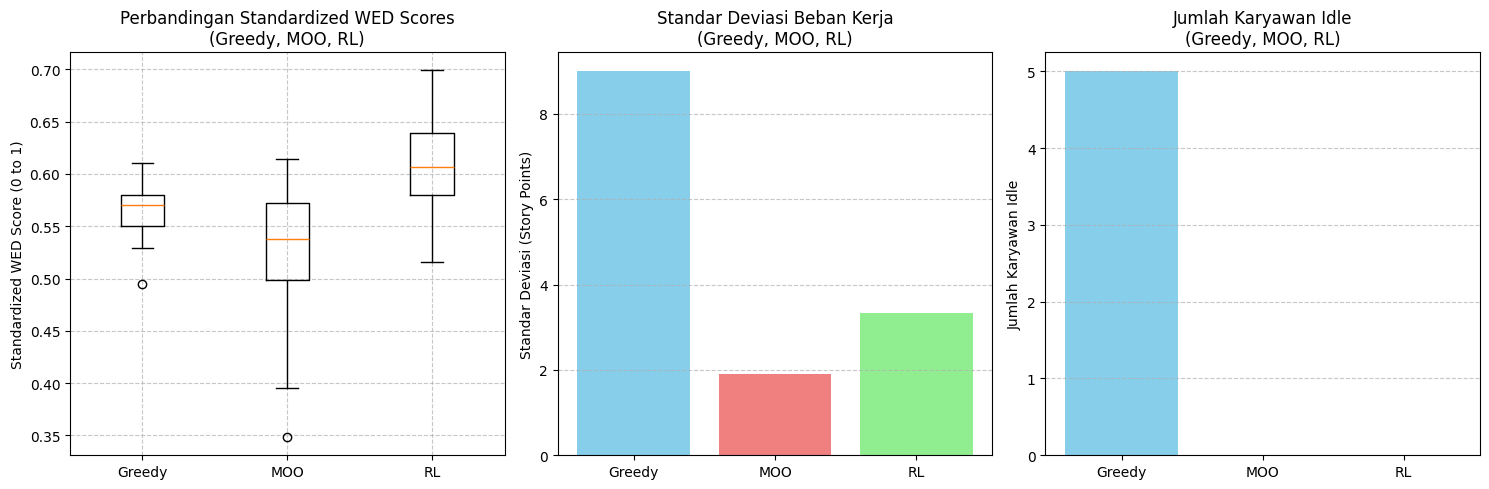


Statistik Standardized WED Scores:
Greedy: Mean=0.567, Median=0.570, Std=0.025
MOO: Mean=0.525, Median=0.538, Std=0.062
RL: Mean=0.607, Median=0.607, Std=0.047

Standar Deviasi Beban Kerja (Story Points):
Greedy: 9.00
MOO: 1.91
RL: 3.33

Jumlah Karyawan Idle:
Greedy: 5
MOO: 0
RL: 0


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from gym import spaces
import random
from collections import deque
import matplotlib.pyplot as plt
import ast
from sklearn.impute import SimpleImputer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Global Variables
# NUM_EMPLOYEES = 12
# NUM_TASKS = 30
# MAX_TASKS = 500
# MAX_EMPLOYEES = 200
# MAX_WORKLOAD = 20
# ALPHA_WED = 0.5
model_save_path = '/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_model_eps50.pth'
agent_save_path = '/content/drive/MyDrive/Skripsi/reassignment_finalcode_dqn_agent_params_eps50.pth'

# --- 1. Greedy Approach ---

# Greedy metrics
story_points_greedy = greedy_df['sum_sp'].tolist()
std_dev_greedy = np.std(story_points_greedy)
num_idle_greedy = np.sum(np.array(story_points_greedy) == 0)

# --- 2. MOO Approach ---

# Load MOO result
path_moo = '/content/drive/MyDrive/Skripsi/Resources/Output/test_result_moo.csv'
result_moo = pd.read_csv(path_moo)

weds_raw_moo = []
for scores_str in result_moo['similarity_score']:
    scores = ast.literal_eval(scores_str)
    weds_raw_moo.extend([(1 / score) - 1 for score in scores])  # Convert similarity to WED

# Standardize WED for MOO (diperbaiki agar konsisten dengan skala [0,5])
wed_raw_worst_moo = np.sqrt(np.sum(1 / (1 + ALPHA_WED * 5) * (0 - 5) ** 2) * len(skill_columns))
weds_standardized_moo = [(wed_raw_worst_moo - wed) / (wed_raw_worst_moo - wed_raw_best) for wed in weds_raw_moo]

# Workload and Idle for MOO
story_points_moo = result_moo.groupby('employee')['sum_sp'].sum()
employee_list_moo = sorted(list(result_moo['employee'].unique()))
story_points_moo_list = [story_points_moo.get(emp, 0) for emp in employee_list_moo]
std_dev_moo = np.std(story_points_moo_list)
num_idle_moo = sum(1 for sp in story_points_moo_list if sp == 0)

# --- 3. RL Inference with Updated DQN ---

# TaskAssignmentEnv for New DQN
class TaskAssignmentEnv(gym.Env):
    def __init__(self, task_data, employee_data, max_tasks=MAX_TASKS, max_employees=MAX_EMPLOYEES):
        super(TaskAssignmentEnv, self).__init__()
        self.num_tasks = NUM_TASKS
        self.num_employees = NUM_EMPLOYEES
        self.max_tasks = max_tasks
        self.max_employees = max_employees
        self.max_workload = MAX_WORKLOAD

        # Load and preprocess data
        task_subset = task_data.iloc[:self.num_tasks]
        employee_subset = employee_data.iloc[:self.num_employees]
        skill_columns = [col for col in task_data.columns if col not in ['task_id', 'story_points', 'project_id']]
        project_id_map = {pid: idx + 1 for idx, pid in enumerate(task_subset['project_id'].unique())}
        project_ids = task_subset['project_id'].map(project_id_map).values
        task_skills_df = task_subset[skill_columns].fillna(0).astype(np.float32)
        employee_skills_df = employee_subset[skill_columns].fillna(0).astype(np.float32)
        story_points_df = task_subset['story_points'].astype(np.float32)

        self.task_skills = F.pad(
            torch.tensor(task_skills_df.values / 5.0, dtype=torch.float32, device=device),
            (0, 0, 0, self.max_tasks - self.num_tasks),
            'constant', 0
        )
        self.employee_skills = F.pad(
            torch.tensor(employee_skills_df.values / 5.0, dtype=torch.float32, device=device),
            (0, 0, 0, self.max_employees - self.num_employees),
            'constant', 0
        )
        self.story_points = F.pad(
            torch.tensor(story_points_df.values, dtype=torch.float32, device=device),
            (0, self.max_tasks - self.num_tasks),
            'constant', 0
        )
        self.project_ids = F.pad(
            torch.tensor(project_ids, dtype=torch.long, device=device),
            (0, self.max_tasks - self.num_tasks),
            'constant', -1
        )
        self.total_story_points = torch.sum(self.story_points[:self.num_tasks]).item()
        self.num_skills = len(skill_columns)

        # Define observation and action spaces
        self.observation_space = spaces.Dict({
            'state_matrix': spaces.Box(low=0, high=1, shape=(self.max_tasks, 5), dtype=np.float32),
            'workload_matrix': spaces.Box(low=0, high=MAX_WORKLOAD, shape=(self.max_employees,), dtype=np.float32),
            'global_features': spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32),
            'task_mask': spaces.Box(low=0, high=1, shape=(self.max_tasks,), dtype=np.float32)
        })
        self.action_space = spaces.MultiDiscrete([2, self.num_tasks, self.num_employees])
        self.reset()

    def reset(self):
        self.workloads = torch.zeros(self.max_employees, device=device, dtype=torch.float32)
        self.assignments = torch.full((self.max_tasks,), -1, dtype=torch.long, device=device)
        self.remaining_tasks = torch.arange(self.num_tasks, device=device, dtype=torch.long)
        self.employee_projects = torch.full((self.max_employees,), -1, dtype=torch.long, device=device)
        self.wed_scores = []
        self.reassign_counts = torch.zeros(self.max_tasks, device=device, dtype=torch.long)
        self.total_reassigns = 0
        self._initialize_state_matrix()
        return self._get_obs()

    def _initialize_state_matrix(self):
        task_skills_expanded = self.task_skills[:self.num_tasks].unsqueeze(1).expand(-1, self.max_employees, -1)
        emp_skills_expanded = self.employee_skills.unsqueeze(0).expand(self.num_tasks, -1, -1)
        diff = emp_skills_expanded - task_skills_expanded
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device)))
        mask = self.task_skills[:self.num_tasks].unsqueeze(1).expand(-1, self.max_employees, -1) > 0
        weighted_diff = weights * mask * (emp_skills_expanded - task_skills_expanded) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff, dim=2))
        num_skills_per_task = torch.sum(self.task_skills[:self.num_tasks] > 0, dim=1).unsqueeze(1).expand(-1, self.max_employees)
        wed_worst = torch.sqrt(num_skills_per_task * (1.0 ** 2))
        wed_worst = torch.where(num_skills_per_task > 0, wed_worst, torch.tensor(1.0, device=device))
        similarity_matrix = (1 - (wed / wed_worst)).to(dtype=torch.float32)
        self.state_matrix = torch.topk(similarity_matrix, k=5, dim=1).values
        self.state_matrix = F.pad(self.state_matrix, (0, 0, 0, self.max_tasks - self.num_tasks), 'constant', 0)

    def _update_state_matrix(self, task_idx, emp_idx):
        task_skills_expanded = self.task_skills[task_idx].unsqueeze(0).expand(self.max_employees, -1)
        emp_skills_expanded = self.employee_skills.expand(self.max_employees, -1)
        diff = emp_skills_expanded - task_skills_expanded
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device)))
        mask = task_skills_expanded > 0
        weighted_diff = weights * mask * (emp_skills_expanded - task_skills_expanded) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff, dim=1))
        num_skills = torch.sum(mask.float(), dim=1)
        wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills[0] > 0 else 1.0
        similarities = 1 - (wed / wed_worst)
        top_k_similarities = torch.topk(similarities, k=5, dim=0).values
        self.state_matrix[task_idx] = top_k_similarities

    def _get_obs(self):
        workload_matrix = self.workloads
        prop_remaining = len(self.remaining_tasks) / self.num_tasks if self.num_tasks > 0 else 0.0
        num_idle = torch.sum(self.workloads[:self.num_employees] == 0).item()
        prop_idle = num_idle / self.num_employees if self.num_employees > 0 else 0.0
        std_workload = torch.std(self.workloads[:self.num_employees]).item() / self.max_workload
        global_features = torch.tensor([prop_remaining, prop_idle, std_workload], device=device, dtype=torch.float32)
        task_mask = torch.zeros(self.max_tasks, device=device, dtype=torch.float32)
        task_mask[self.remaining_tasks] = 1
        return {
            'state_matrix': self.state_matrix,
            'workload_matrix': workload_matrix,
            'global_features': global_features,
            'task_mask': task_mask
        }

    def step(self, action):
        action_type, task_idx, emp_idx = action
        done = False
        reward = {'similarity': 0.0, 'workload': 0.0, 'idle': 0.0}
        info = {'action_valid': True}

        if emp_idx < 0 or emp_idx >= self.num_employees or task_idx < 0 or task_idx >= self.num_tasks:
            reward['similarity'] = -1.0
            info['action_valid'] = False
            return self._get_obs(), reward, done, info

        current_std = torch.std(self.workloads[:self.num_employees]).item()

        if action_type == 0:
            if task_idx not in self.remaining_tasks:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info

            task_project = self.project_ids[task_idx]
            emp_project = self.employee_projects[emp_idx]
            current_workload = self.workloads[emp_idx]
            if emp_project != -1 and emp_project != task_project:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info
            if current_workload + self.story_points[task_idx] > self.max_workload:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info

            was_idle = (self.workloads[emp_idx] == 0)
            self.assignments[task_idx] = emp_idx
            self.workloads[emp_idx] += self.story_points[task_idx]
            self.remaining_tasks = self.remaining_tasks[self.remaining_tasks != task_idx]
            if self.employee_projects[emp_idx] == -1:
                self.employee_projects[emp_idx] = task_project
            self._update_state_matrix(task_idx, emp_idx)

        elif action_type == 1:
            if task_idx in self.remaining_tasks:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info
            if self.reassign_counts[task_idx] >= 3:  # MAX_REASSIGN_PER_TASK from training
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info

            current_emp_idx = self.assignments[task_idx]
            if current_emp_idx == emp_idx:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info
            task_project = self.project_ids[task_idx]
            emp_project = self.employee_projects[emp_idx]
            current_workload = self.workloads[emp_idx]
            if emp_project != -1 and emp_project != task_project:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info
            if current_workload + self.story_points[task_idx] > self.max_workload:
                reward['similarity'] = -1.0
                info['action_valid'] = False
                return self._get_obs(), reward, done, info

            self.workloads[current_emp_idx] -= self.story_points[task_idx]
            emp_tasks = (self.assignments == current_emp_idx) & (self.project_ids == task_project)
            emp_tasks[task_idx] = False
            if not torch.any(emp_tasks):
                self.employee_projects[current_emp_idx] = -1
            was_idle = (self.workloads[emp_idx] == 0)
            self.assignments[task_idx] = emp_idx
            self.workloads[emp_idx] += self.story_points[task_idx]
            if self.employee_projects[emp_idx] == -1:
                self.employee_projects[emp_idx] = task_project
            self.reassign_counts[task_idx] += 1
            self.total_reassigns += 1
            self._update_state_matrix(task_idx, emp_idx)

        else:
            reward['similarity'] = -1.0
            info['action_valid'] = False
            return self._get_obs(), reward, done, info

        new_std = torch.std(self.workloads[:self.num_employees]).item()
        std_change = new_std - current_std
        if std_change < 0:
            reward['workload'] += 0.5
        elif std_change > 0:
            reward['workload'] -= 0.3

        task_skills_t = self.task_skills[task_idx]
        emp_skills_e = self.employee_skills[emp_idx]
        diff = emp_skills_e - task_skills_t
        weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device)))
        mask = task_skills_t > 0
        weighted_diff = weights[mask] * (emp_skills_e[mask] - task_skills_t[mask]) ** 2
        wed = torch.sqrt(torch.sum(weighted_diff))
        num_skills = torch.sum(mask.float())
        wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills > 0 else 1.0
        similarity = 1 - (wed / wed_worst) if wed_worst > 0 else 0.0
        info['similarity'] = similarity.item()
        self.wed_scores.append(wed.item())

        if action_type == 0:
            reward['similarity'] = similarity.item()
            if was_idle:
                reward['idle'] = 0.1
        else:
            reward['similarity'] = 0.0  # Adjusted based on training code

        if len(self.remaining_tasks) == 0:
            done = True
            assigned_tasks = torch.where(self.assignments != -1)[0]
            total_similarity = 0.0
            for task_idx in assigned_tasks:
                emp_idx = self.assignments[task_idx].item()
                task_skills_t = self.task_skills[task_idx]
                emp_skills_e = self.employee_skills[emp_idx]
                diff = emp_skills_e - task_skills_t
                weights = 1 / (1 + ALPHA_WED * torch.maximum(diff, torch.tensor(0.0, device=device)))
                mask = task_skills_t > 0
                weighted_diff = weights[mask] * (emp_skills_e[mask] - task_skills_t[mask]) ** 2
                wed = torch.sqrt(torch.sum(weighted_diff))
                num_skills = torch.sum(mask.float())
                wed_worst = torch.sqrt(num_skills * (1.0 ** 2)) if num_skills > 0 else 1.0
                similarity = 1 - (wed / wed_worst) if wed_worst > 0 else 0.0
                total_similarity += similarity
            avg_similarity = (total_similarity / self.num_tasks if self.num_tasks > 0 else 0.0).item()
            reward['similarity'] += 50.0 * (2.0 * avg_similarity - 1.0)
            std_workload = torch.std(self.workloads[:self.num_employees]).item()
            max_std = self.max_workload / 2
            normalized_std = std_workload / max_std if max_std > 0 else 0.0
            reward['workload'] = 100.0 * (1.0 - 2.0 * normalized_std)
            num_idle = torch.sum(self.workloads[:self.num_employees] == 0).item()
            idle_ratio = num_idle / self.num_employees
            reward['idle'] += 50.0 * (1.0 - 2.0 * idle_ratio)
            info['avg_similarity'] = avg_similarity
            info['std_workload'] = std_workload
            info['num_idle'] = num_idle

        return self._get_obs(), reward, done, info

# DQN Model
class DQN(nn.Module):
    def __init__(self, input_dim, max_employees, max_tasks, num_employees, num_tasks):
        super(DQN, self).__init__()
        self.max_employees = max_employees
        self.max_tasks = max_tasks
        self.num_employees = num_employees
        self.num_tasks = num_tasks
        self.fc_state = nn.Linear(max_tasks * 5, 128).to(device, dtype=torch.float32)
        self.fc_workload = nn.Linear(max_employees, 64).to(device, dtype=torch.float32)
        self.fc_global = nn.Linear(3, 16).to(device, dtype=torch.float32)
        self.fc_combined = nn.Linear(128 + 64 + 16, 256).to(device, dtype=torch.float32)
        self.fc2 = nn.Linear(256, 128).to(device, dtype=torch.float32)
        self.fc3 = nn.Linear(128, 2 * max_tasks * max_employees).to(device, dtype=torch.float32)

    def forward(self, state_matrix, workload_matrix, global_features):
        batch_size = state_matrix.size(0)
        state_input = state_matrix.view(batch_size, -1)
        state_input = F.relu(self.fc_state(state_input))
        workload_input = workload_matrix.view(batch_size, -1)
        workload_input = F.relu(self.fc_workload(workload_input))
        global_input = global_features.view(batch_size, -1)
        global_input = F.relu(self.fc_global(global_input))
        x = torch.cat([state_input, workload_input, global_input], dim=1)
        x = F.relu(self.fc_combined(x))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x).view(batch_size, 2, self.max_tasks, self.max_employees)
        q_values[:, :, self.num_tasks:, :] = -float('inf')
        q_values[:, :, :, self.num_employees:] = -float('inf')
        return q_values

# DQN Agent
class DQNAgent:
    def __init__(self, num_tasks, num_employees):
        self.device = device
        self.num_tasks = num_tasks
        self.num_employees = num_employees
        self.max_tasks = MAX_TASKS
        self.max_employees = MAX_EMPLOYEES
        self.model = DQN(1 + 1 + 1 + 4, self.max_employees, self.max_tasks, self.num_employees, self.num_tasks).to(device)
        self.target_model = DQN(1 + 1 + 1 + 4, self.max_employees, self.max_tasks, self.num_employees, self.num_tasks).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=3e-4)
        self.memory = deque(maxlen=50000)
        self.temperature = 1.0
        self.epsilon = 0.05

    def act(self, obs, env):
        valid_tasks = torch.where(obs['task_mask'][:self.num_tasks] == 1)[0]
        assigned_tasks = torch.where(env.assignments[:self.num_tasks] != -1)[0]

        if random.random() < self.epsilon:
            if len(valid_tasks) > 0 and random.random() < 0.8:
                task_idx = random.choice(valid_tasks.cpu().numpy())
                valid_emps = torch.where(
                    (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                    ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                )[0]
                if valid_emps.size(0) > 0:
                    emp_idx = random.choice(valid_emps.cpu().numpy())
                    return [0, task_idx, emp_idx]
            else:
                if len(assigned_tasks) == 0:
                    task_idx = random.choice(valid_tasks.cpu().numpy())
                    valid_emps = torch.where(
                        (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                        ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                    )[0]
                    if valid_emps.size(0) > 0:
                        emp_idx = random.choice(valid_emps.cpu().numpy())
                        return [0, task_idx, emp_idx]
                task_idx = random.choice(assigned_tasks.cpu().numpy())
                current_emp_idx = env.assignments[task_idx].item()
                valid_emps = torch.where(
                    (torch.arange(self.num_employees, device=device) != current_emp_idx) &
                    (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                    ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                )[0]
                if valid_emps.size(0) > 0:
                    emp_idx = random.choice(valid_emps.cpu().numpy())
                    return [1, task_idx, emp_idx]

        state_matrix = obs['state_matrix'].unsqueeze(0).to(dtype=torch.float32)
        workload_matrix = obs['workload_matrix'].unsqueeze(0).to(dtype=torch.float32)
        global_features = obs['global_features'].unsqueeze(0).to(dtype=torch.float32)

        with torch.no_grad():
            q_values = self.model(state_matrix, workload_matrix, global_features)
            task_mask = torch.zeros(self.max_tasks, device=device, dtype=torch.bool)
            task_mask[valid_tasks] = 1
            emp_mask = torch.ones(self.max_tasks, self.max_employees, device=device, dtype=torch.bool)
            for t in range(self.num_tasks):
                emp_mask[t, :self.num_employees] = (
                    (env.workloads[:self.num_employees] + env.story_points[t] <= env.max_workload) &
                    ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[t]))
                )
                emp_mask[t, self.num_employees:] = False
            assign_mask = torch.zeros_like(q_values, dtype=torch.bool)
            assign_mask[:, 0] = task_mask.unsqueeze(-1).expand(-1, self.max_employees) & emp_mask
            reassign_mask = torch.zeros_like(q_values, dtype=torch.bool)
            for t in assigned_tasks:
                if env.reassign_counts[t] < 3:  # MAX_REASSIGN_PER_TASK from training
                    current_emp_idx = env.assignments[t].item()
                    reassign_emp_mask = emp_mask[t].clone()
                    reassign_emp_mask[current_emp_idx] = False
                    reassign_mask[0, 1, t] = reassign_emp_mask
            combined_mask = assign_mask | reassign_mask
            q_values[~combined_mask] = -float('inf')

            if torch.all(q_values == -float('inf')):
                if len(valid_tasks) > 0:
                    task_idx = random.choice(valid_tasks.cpu().numpy())
                    valid_emps = torch.where(
                        (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                        ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                    )[0]
                    if valid_emps.size(0) > 0:
                        emp_idx = random.choice(valid_emps.cpu().numpy())
                        return [0, task_idx, emp_idx]
                else:
                    task_idx = random.choice(assigned_tasks.cpu().numpy())
                    current_emp_idx = env.assignments[task_idx].item()
                    valid_emps = torch.where(
                        (torch.arange(self.num_employees, device=device) != current_emp_idx) &
                        (env.workloads[:self.num_employees] + env.story_points[task_idx] <= env.max_workload) &
                        ((env.employee_projects[:self.num_employees] == -1) | (env.employee_projects[:self.num_employees] == env.project_ids[task_idx]))
                    )[0]
                    if valid_emps.size(0) > 0:
                        emp_idx = random.choice(valid_emps.cpu().numpy())
                        return [1, task_idx, emp_idx]
            else:
                action_idx = torch.argmax(q_values.view(-1)).item()
                action_type = action_idx // (self.max_tasks * self.max_employees)
                task_emp_idx = action_idx % (self.max_tasks * self.max_employees)
                task_idx = task_emp_idx // self.max_employees
                emp_idx = task_emp_idx % self.max_employees
                return [action_type, task_idx, emp_idx]

    def load(self, model_path, agent_path):
            checkpoint = torch.load(model_path, map_location=torch.device('cpu')) # Added map_location argument
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.target_model.load_state_dict(checkpoint['target_model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            agent_params = torch.load(agent_path, map_location=torch.device('cpu'), weights_only=False) # Added map_location argument
            self.temperature = agent_params['temperature']
            self.epsilon = agent_params['epsilon']
            self.memory = deque(maxlen=50000)

# RL Inference
def run_inference():
    env = TaskAssignmentEnv(task_data, employee_data)
    agent = DQNAgent(env.num_tasks, env.num_employees)
    agent.load(model_save_path, agent_save_path)

    obs = env.reset()
    done = False
    while not done:
        action = agent.act(obs, env)
        next_obs, reward, done, info = env.step(action)
        obs = next_obs

    weds_raw_rl = env.wed_scores
    workloads_rl = env.workloads[:env.num_employees].cpu().numpy()
    num_idle_rl = info.get('num_idle', torch.sum(env.workloads[:env.num_employees] == 0).item())
    std_workloads_rl = info.get('std_workload', torch.std(env.workloads[:env.num_employees]).item())

    return weds_raw_rl, workloads_rl, std_workloads_rl, num_idle_rl

# Run RL inference
weds_raw_rl, workloads_rl, std_dev_rl, num_idle_rl = run_inference()

# Standardize WED for RL
weds_standardized_rl = [(wed_raw_worst_greedy - wed) / (wed_raw_worst_greedy - wed_raw_best) for wed in weds_raw_rl]

# --- 4. Visualisasi Perbandingan ---

weds_standardized_all = {
    'Greedy': weds_standardized_greedy,
    'MOO': weds_standardized_moo,
    'RL': weds_standardized_rl
}

std_devs = {
    'Greedy': std_dev_greedy,
    'MOO': std_dev_moo,
    'RL': std_dev_rl
}

idle_employees = {
    'Greedy': num_idle_greedy,
    'MOO': num_idle_moo,
    'RL': num_idle_rl
}

# Visualisasi
plt.figure(figsize=(15, 5))

# Boxplot WED Scores
plt.subplot(1, 3, 1)
plt.boxplot(weds_standardized_all.values(), labels=weds_standardized_all.keys())
plt.title("Perbandingan Standardized WED Scores\n(Greedy, MOO, RL)")
plt.ylabel("Standardized WED Score (0 to 1)")
plt.grid(True, linestyle='--', alpha=0.7)

# Bar Chart Standar Deviasi Beban Kerja
plt.subplot(1, 3, 2)
plt.bar(std_devs.keys(), std_devs.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Standar Deviasi Beban Kerja\n(Greedy, MOO, RL)")
plt.ylabel("Standar Deviasi (Story Points)")
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Bar Chart Jumlah Karyawan Idle
plt.subplot(1, 3, 3)
plt.bar(idle_employees.keys(), idle_employees.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("Jumlah Karyawan Idle\n(Greedy, MOO, RL)")
plt.ylabel("Jumlah Karyawan Idle")
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

plt.tight_layout()
plt.savefig('comparison_final_greedy_moo_rl.png')
plt.show()

# Statistik Tambahan
print("\nStatistik Standardized WED Scores:")
for approach, weds in weds_standardized_all.items():
    print(f"{approach}: Mean={np.mean(weds):.3f}, Median={np.median(weds):.3f}, Std={np.std(weds):.3f}")

print("\nStandar Deviasi Beban Kerja (Story Points):")
for approach, std_dev in std_devs.items():
    print(f"{approach}: {std_dev:.2f}")

print("\nJumlah Karyawan Idle:")
for approach, num_idle in idle_employees.items():
    print(f"{approach}: {num_idle}")